In [1]:
#USE PRE-TRAINED WORD EMBEDDINGS, e.g. gloVe, spaCy, word2vec, etc.

In [4]:
#load the data
import os
import pandas as pd

os.chdir('/Users/jacksonwalters/tensorflow_datasets')

filepath_dict = {'tweet':   'labeled_tweets/all_labeled_tweets.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Tune in 11:30 ET tomorrow for a live webcast o...
label                                                       0
source                                                  tweet
Name: 0, dtype: object


In [36]:
#vectorize the data
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
#slice the df to get yelp sentences
df_tweet = df[df['source'] == 'tweet']
sentences = df_tweet['sentence'].values
#tweet sentence sentiment labels. 0 = negative, 1 = positive
y = df_tweet['label'].values
#split the sentences into training data and test data
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)
#vectorize the sentences
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1; vocab_size  
#pad_sequences
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [37]:
#create an embedding matrix. index of word corresponds to wordvector.
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [7]:
embedding_dim = 10
embedding_matrix = create_embedding_matrix('glove/glove.6B.50d.txt',
                                           tokenizer.word_index, embedding_dim)

In [8]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))

In [9]:
nonzero_elements / vocab_size

0.5877929436003091

In [10]:
#build a model a layer with pretrained weights. that is,
#we're setting the weights of the first layer to just give 
#the wordvector
from tensorflow import keras
from keras import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 10)           194150    
                                                                 
 global_max_pooling1d (Globa  (None, 10)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 194,271
Trainable params: 121
Non-trainable params: 194,150
_________________________________________________________________


In [11]:
#function to plot model metrics
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

2022-01-12 22:50:29.565068: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-12 22:50:29.744074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-12 22:50:35.253386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training Accuracy: 0.7752
Testing Accuracy:  0.7834


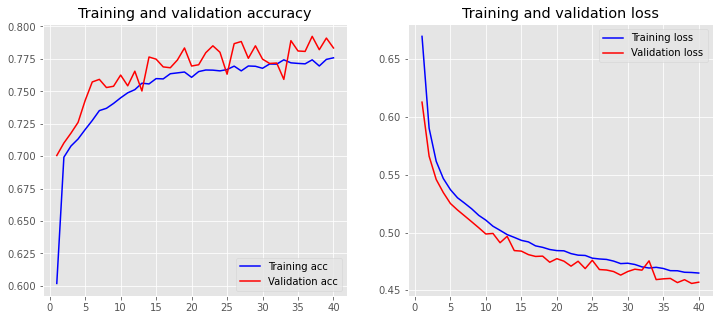

In [12]:
#train the model
history = model.fit(X_train, y_train,
                    epochs=40,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [51]:
#test examples
ex_sent = "taxes"
X_ex_sent = tokenizer.texts_to_sequences([ex_sent])
model.predict(pad_sequences(X_ex_sent, padding='post', maxlen=maxlen))

array([[0.7088642]], dtype=float32)